In [1]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Osama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_classification_df = pd.read_csv("/Users/Osama/Downloads/CS412PROJ/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [4]:
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [5]:
username2_category["kod8net"]

'tech'

In [6]:
train_data_path = "/Users/Osama/Downloads/CS412PROJ/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile

In [7]:
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [8]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji


def preprocess_text(text: str):
    

    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    #text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)



#custom_stopwords = list(set(turkish_stopwords).union({
 #   'the', 'and', 'with', 'for', 'you', 'to', 'of', 'in', 'our', 'your', 'is', 'are','bir'
#}))
vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=10000,min_df=10)

# fit the vectorizer
vectorizer.fit(corpus)

# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]
feature_names = vectorizer.get_feature_names_out()

# Inspect the frequency of each word
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)

# Show the most frequent words (words in many posts)
print(df_tfidf.sum().sort_values(ascending=False).head(30))




test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [1038]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [1039]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['ab', 'abant', 'abd', ..., 'şıklığı', 'şıklığın', 'şımartın'],
      dtype=object)

In [1040]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,ab,abant,abd,abdulkadir,abdullah,abi,ability,abiye,able,abone,...,şükranla,şükranlarımı,şükranlarımızı,şükür,şükürler,şık,şıklık,şıklığı,şıklığın,şımartın
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.04418,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


In [1041]:
df_tfidf.shape

(2741, 10000)

In [1042]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [1043]:
x_train.shape

(2192, 10000)

In [1044]:
x_val.shape

(549, 10000)

In [1045]:
'''from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


model = MultinomialNB()
model.fit(x_train, y_train)'''
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import numpy as np
from collections import Counter

# Count the number of users in each class
class_counts = Counter(y_train)

# Total number of samples
total_samples = len(y_train)

# Calculate class weights using log10
log_class_weights = {
    cls: np.log10(1 + total_samples / count)  # Logarithmic scaling of class weight
    for cls, count in class_counts.items()
}

print("Class Weights with Log10 scaling:", log_class_weights)

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print("Class Weights:", class_weight_dict)


from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Initialize SVM model with class weights
svm_model = LinearSVC(class_weight=log_class_weights,max_iter=2000,random_state=42)




#svm_model = LinearSVC(class_weight=class_weight_dict, max_iter=2000)
#non_linear_svm = SVC(kernel='rbf', class_weight=log_class_weights,max_iter=2000,random_state=42)
# Train the model
svm_model.fit(x_train, y_train)

Class Weights with Log10 scaling: {'art': np.float64(1.1854514162335033), 'health and lifestyle': np.float64(0.8097439186635912), 'fashion': np.float64(1.007387057895198), 'travel': np.float64(1.0140019140601984), 'food': np.float64(0.8034170441885309), 'tech': np.float64(0.9500413208674837), 'entertainment': np.float64(0.9775463784013023), 'mom and children': np.float64(1.2882529840865786), 'sports': np.float64(1.4040731306428709), 'gaming': np.float64(2.3428173146357327)}
Class Weights: {np.str_('art'): np.float64(1.4326797385620915), np.str_('entertainment'): np.float64(0.8496124031007752), np.str_('fashion'): np.float64(0.9171548117154812), np.str_('food'): np.float64(0.5359413202933986), np.str_('gaming'): np.float64(21.92), np.str_('health and lifestyle'): np.float64(0.545273631840796), np.str_('mom and children'): np.float64(1.842016806722689), np.str_('sports'): np.float64(2.4355555555555557), np.str_('tech'): np.float64(0.7913357400722022), np.str_('travel'): np.float64(0.9327

LinearSVC(class_weight={'art': np.float64(1.1854514162335033),
                        'entertainment': np.float64(0.9775463784013023),
                        'fashion': np.float64(1.007387057895198),
                        'food': np.float64(0.8034170441885309),
                        'gaming': np.float64(2.3428173146357327),
                        'health and lifestyle': np.float64(0.8097439186635912),
                        'mom and children': np.float64(1.2882529840865786),
                        'sports': np.float64(1.4040731306428709),
                        'tech': np.float64(0.9500413208674837),
                        'travel': np.float64(1.0140019140601984)},
          max_iter=2000, random_state=42)

In [1046]:
'''from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42)
rf_model.fit(x_train, y_train)

# Evaluate
y_pred = rf_model.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy (Random Forest): {accuracy:.2f}")'''

'from sklearn.ensemble import RandomForestClassifier\n\n# Initialize and train the model\nrf_model = RandomForestClassifier(class_weight=\'balanced\',random_state=42)\nrf_model.fit(x_train, y_train)\n\n# Evaluate\ny_pred = rf_model.predict(x_val)\naccuracy = accuracy_score(y_val, y_pred)\nprint(f"Test Accuracy (Random Forest): {accuracy:.2f}")'

In [1047]:
'''from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svm_model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)'''


"from sklearn.model_selection import GridSearchCV\nparam_grid = {'svc__C': [1, 5, 10, 50],\n              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}\ngrid = GridSearchCV(svm_model, param_grid)\n\n%time grid.fit(Xtrain, ytrain)\nprint(grid.best_params_)"

In [1048]:
#@title Train Data
y_train_pred = svm_model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Accuracy: 0.9931569343065694

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.99      0.99       153
       entertainment       1.00      0.99      1.00       258
             fashion       0.99      1.00      0.99       239
                food       0.98      1.00      0.99       409
              gaming       1.00      1.00      1.00        10
health and lifestyle       1.00      0.99      0.99       402
    mom and children       0.99      1.00      1.00       119
              sports       1.00      1.00      1.00        90
                tech       0.99      1.00      0.99       277
              travel       1.00      0.99      0.99       235

            accuracy                           0.99      2192
           macro avg       1.00      0.99      0.99      2192
        weighted avg       0.99      0.99      0.99      2192



In [ ]:
y_val_pred = svm_model.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Accuracy: 0.6703096539162113

Classification Report:
                      precision    recall  f1-score   support

                 art       0.48      0.26      0.34        38
       entertainment       0.47      0.43      0.45        65
             fashion       0.66      0.82      0.73        60
                food       0.83      0.89      0.86       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.67      0.64      0.65       100
    mom and children       0.50      0.40      0.44        30
              sports       0.56      0.61      0.58        23
                tech       0.65      0.80      0.72        69
              travel       0.80      0.76      0.78        59

            accuracy                           0.67       549
           macro avg       0.56      0.56      0.56       549
        weighted avg       0.66      0.67      0.66       549

Confusion Matrix:
 [[10  9  6  2  0  4  2  0  3  2]
 [ 2 28  7  7  0  6  2  

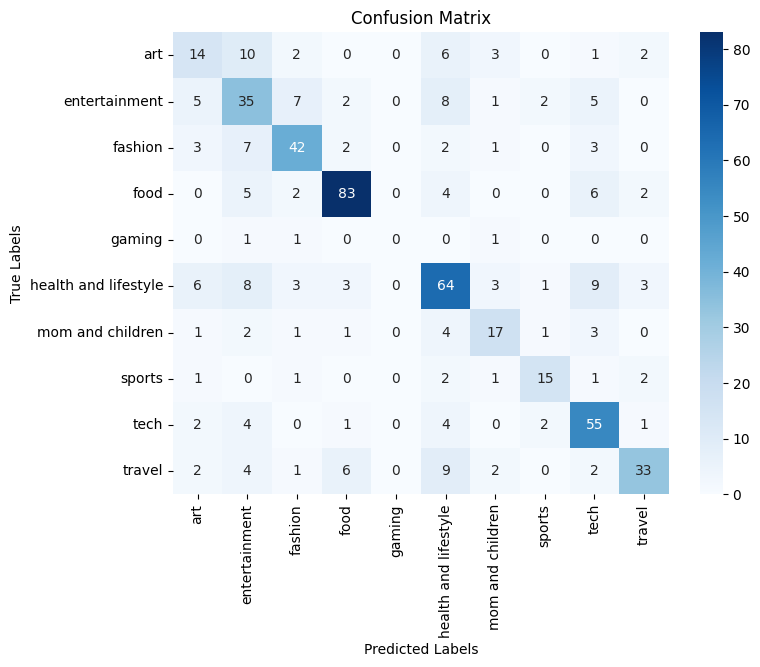

In [381]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [105]:
# Ensure that validation data is properly referenced
# Assuming you have a list of usernames and captions for the validation set
val_usernames = train_usernames[len(x_train):]  # Example placeholder
val_corpus = corpus[len(x_train):]  # Example placeholder

# Ensure y_val and y_val_pred are aligned with validation usernames
y_val_aligned = y_val[:len(val_usernames)]
y_val_pred_aligned = y_val_pred[:len(val_usernames)]

# Recreate the DataFrame for validation data
val_data = pd.DataFrame({
    "Username": val_usernames,
    "True Label": y_val_aligned,
    "Predicted Label": y_val_pred_aligned,
    "Captions": val_corpus
})

# Identify misclassified samples
misclassified = val_data[val_data["True Label"] != val_data["Predicted Label"]]

# Print misclassified samples with their captions
print("Misclassified Samples with Captions:")
for _, row in misclassified.iterrows():
    print(f"Username: {row['Username']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print(f"Captions: {row['Captions']}\n")


Misclassified Samples with Captions:
Username: zekiinal09
True Label: mom and children
Predicted Label: entertainment
Captions: bugün cabi muhtarım tayfun karaoğlan geyre muhtarım nevcet çoban tekeliler muhtarım serkan anil çamarasi muhtarım yusuf sevim yolalti muhtarım ali kocaağoğlu dikmen muhtarım hüseyin çeker yaykin muhtarım osman ali aktan ve güzelbeyli muhtarım celal ingay ile yaklaşan yerel seçimler ile ilgili sohbet ettik hoş sohbetlerinden dolayı kendilerine teşekkür ediyorum
birine çamur atmadan önce düşün ve sakin unutma ilk önce senin ellerin kirlenecek sağlikli mutlu bereketli bir hafta dileğiyle hayirli haftalar diliyorum
ilçemiz palamutçuk mahallesi şöför esnaflarımızdan ahmet kaya kardeşimizin oğlunun asker yemeğine katıldık allah kabul etsin sağ salim gidip gelmeyi nasip etsin inşaallah
bugün ilçemiz esnaf kefalet odası başkanı recep karataşziraat odası başkanı ibrahim iren şöförler odası başkanı mustafa gülgen ve iyi parti kadın kolları başkanı nihal deliktaşı ziyare

In [76]:
#@title Test Data
test_data_path = "/Users/Osama/Downloads/CS412PROJ/test-classification-round2.dat"

with open(test_data_path, "rt") as fh:
    for i, line in enumerate(fh):
        print(line.strip())
        if i >= 4:  # Stop after 5 lines
            break

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])

ozhotelstr
elleturkiye
sozerinsaatorhangazi
sanliurfapiazzaavym
rusanozden
*****
['ozhotelstr', 'elleturkiye', 'sozerinsaatorhangazi', 'sanliurfapiazzaavym', 'rusanozden']


In [77]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


test_unames.remove("screenname")

screenname


In [84]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

,abdullah,abone,about,accompanied,acele,acil,activities,acı,ad,ada,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.013628,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.025994,0.0,0.0,0.011087,0.0,0.0


In [82]:
y_test_pred = mlp_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_test_pred))

NameError: name 'y_test' is not defined